In [1]:
from __future__ import annotations

import hist
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mplhep as hep
import numpy as np
import pandas as pd
import vector
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import HH4b.utils as utils

hep.style.use(["CMS", "firamath"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

/Users/cmantill/miniconda3/envs/coffea/lib/python3.8/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [3]:
samples = {
    "qcd": [
        "QCD_HT-200to400",
        "QCD_HT-400to600",
        "QCD_HT-600to800",
        "QCD_HT-800to1000",
        "QCD_HT-1000to1200",
        "QCD_HT-1200to1500",
        "QCD_HT-1500to2000",
        "QCD_HT-2000",
    ],
    "ttbar": [
        "TTto4Q",
        "TTtoLNu2Q",
    ],
    "hh4b": [
        "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV",
    ],
    "hh4b_private": [
        "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_private",
    ],
}

MAIN_DIR = "../../../"
year = "2022EE"
dir_name = "24Mar2_v12_signal"
path_to_dir = f"{MAIN_DIR}/../data/skimmer/{dir_name}/"
dirs = {path_to_dir: samples}

# columns to load
load_columns = [
    ("weight", 1),
    ("MET_pt", 1),
    ("nFatJets", 1),
    ("bbFatJetPt", 2),
    ("bbFatJetEta", 2),
    ("bbFatJetPhi", 2),
    ("bbFatJetMsd", 2),
    ("bbFatJetPNetMass", 2),
    ("bbFatJetPNetXbb", 2),
    ("bbFatJetTau3OverTau2", 2),
    ("bbFatJetPNetQCD0HF", 2),
    ("bbFatJetPNetQCD1HF", 2),
    ("bbFatJetPNetQCD2HF", 2),
]
# reformat into ("column name", "idx") format for reading multiindex columns
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")

filters = [
    [
        ("('bbFatJetPt', '0')", ">=", 300),
        ("('bbFatJetPt', '1')", ">=", 300),
        ("('bbFatJetMsd', '0')", "<=", 250),
        ("('bbFatJetMsd', '1')", "<=", 250),
        ("('bbFatJetMsd', '0')", ">=", 50),
        ("('bbFatJetMsd', '1')", ">=", 50),
        ("('MET_pt', '0')", "<=", 1000),
    ],
]

events_dict = {}
for input_dir, samples in dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters, columns_mc=columns),
    }


print("Keys:")
print(events_dict.keys())
for key in events_dict:
    print(key, len(events_dict[key]))

samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print(keys_loaded)

Loading QCD_HT-2000
Loading QCD_HT-400to600
Loading QCD_HT-800to1000
Loading QCD_HT-600to800
Loading QCD_HT-1500to2000
Loading QCD_HT-200to400
Loading QCD_HT-1000to1200
Loading QCD_HT-1200to1500
Loading TTtoLNu2Q
Loading TTto4Q
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV
Keys:
dict_keys(['qcd', 'ttbar', 'hh4b'])
qcd 606602
ttbar 1013232
hh4b 92437
[('weight', 0), ('MET_pt', 0), ('nFatJets', 0), ('bbFatJetPt', 0), ('bbFatJetPt', 1), ('bbFatJetEta', 0), ('bbFatJetEta', 1), ('bbFatJetPhi', 0), ('bbFatJetPhi', 1), ('bbFatJetMsd', 0), ('bbFatJetMsd', 1), ('bbFatJetPNetMass', 0), ('bbFatJetPNetMass', 1), ('bbFatJetPNetXbb', 0), ('bbFatJetPNetXbb', 1), ('bbFatJetTau3OverTau2', 0), ('bbFatJetTau3OverTau2', 1), ('bbFatJetPNetQCD0HF', 0), ('bbFatJetPNetQCD0HF', 1), ('bbFatJetPNetQCD1HF', 0), ('bbFatJetPNetQCD1HF', 1), ('bbFatJetPNetQCD2HF', 0), ('bbFatJetPNetQCD2HF', 1), ('weight_nonorm', '')]


Make BDT dataframe

In [4]:
def bdt_dataframe(key):
    events = events_dict[key]

    h1 = vector.array(
        {
            "pt": events["bbFatJetPt"].to_numpy()[:, 0],
            "phi": events["bbFatJetPhi"].to_numpy()[:, 0],
            "eta": events["bbFatJetEta"].to_numpy()[:, 0],
            "M": events["bbFatJetMsd"].to_numpy()[:, 0],
        }
    )
    h2 = vector.array(
        {
            "pt": events["bbFatJetPt"].to_numpy()[:, 1],
            "phi": events["bbFatJetPhi"].to_numpy()[:, 1],
            "eta": events["bbFatJetEta"].to_numpy()[:, 1],
            "M": events["bbFatJetMsd"].to_numpy()[:, 1],
        }
    )
    hh = h1 + h2

    # bdt variables
    df = pd.DataFrame(
        {
            # dihiggs system
            "HHlogPt": np.log(hh.pt),
            "HHeta": hh.eta,
            "HHmass": hh.mass,
            # met in the event
            "MET": events.MET_pt[0],
            # fatjet tau32
            "H1T32": events["bbFatJetTau3OverTau2"].to_numpy()[:, 0],
            "H2T32": events["bbFatJetTau3OverTau2"].to_numpy()[:, 1],
            # fatjet mass
            "H1Msd": events["bbFatJetMsd"].to_numpy()[:, 0],
            "H2Msd": events["bbFatJetMsd"].to_numpy()[:, 1],
            # fatjet kinematics
            "H1logPt": np.log(h1.pt),
            "H2logPt": np.log(h2.pt),
            "H1eta": h1.eta,
            "H2eta": h2.eta,
            "H1_dRH2": h1.deltaR(h2),
            "H1_dPhiH2": h1.deltaphi(h2),
            # xbb
            "H1Xbb": events["bbFatJetPNetXbb"].to_numpy()[:, 0],
            "H1QCD1HF": events["bbFatJetPNetQCD1HF"].to_numpy()[:, 0],
            "H1QCD2HF": events["bbFatJetPNetQCD2HF"].to_numpy()[:, 0],
            "H1QCD0HF": events["bbFatJetPNetQCD0HF"].to_numpy()[:, 0],
            # ratios
            "H1Pt_HHmass": h1.pt / hh.mass,
            "H2Pt_HHmass": h2.pt / hh.mass,
            "H1Pt/H2Pt": h1.pt / h2.pt,
        }
    )
    df.replace(np.inf, 10000, inplace=True)
    df.replace(-np.inf, 10000, inplace=True)

    return df


events_dict_bdt = {}
weights_bdt = {}
for key in events_dict.keys():
    events_dict_bdt[key] = bdt_dataframe(key)
    weights_bdt[key] = np.abs(events_dict[key]["weight"].to_numpy()[:, 0])

Make BDT inputs

In [5]:
variables_not_in_bdt = [
    # not use PnetMass until we debug it
    # "H1PNetMass",
    # not use H2 mass to avoid correlations
    "H2Msd",
    # "H2PNetMass",
    # not use H2Xbb so that we can further cut on it
    # "H2Xbb",
    # these sculpt the mass
    "H1_dRH2",
    "H1_dPhiH2",
]

events = pd.concat(
    [events_dict_bdt["hh4b"], events_dict_bdt["qcd"], events_dict_bdt["ttbar"]],
    keys=["hh4b", "qcd", "ttbar"],
)
events["target"] = 0  # Default to 0 (background)
events.loc["hh4b", "target"] = 1  # Set to 1 for 'hh4b' samples (signal)

# weights
# events["weight"] = np.concatenate((weights_bdt["hh4b"], weights_bdt["qcd"], weights_bdt["ttbar"]))
sig_total = np.sum(weights_bdt["hh4b"])
# scale signal such that total signal = total background
bkg_total = np.sum(np.concatenate((weights_bdt["qcd"], weights_bdt["ttbar"])))
print(f"Scale signal by {bkg_total / sig_total}")
events.loc["hh4b", "weight"] = weights_bdt["hh4b"] * (bkg_total / sig_total)
events.loc["qcd", "weight"] = weights_bdt["qcd"]
events.loc["ttbar", "weight"] = weights_bdt["ttbar"]

# Define target
target = events["target"]

# Define weights
weights_to_use = events["weight"]

# load features into pandas df
features = events
features.drop(columns=variables_not_in_bdt, inplace=True)
features.drop(columns=["target"], inplace=True)

print(features)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.4,
    random_state=42,
)

weights_train = X_train["weight"].copy()
X_train.drop(columns=["weight"], inplace=True)
weights_test = X_test["weight"].copy()
X_test.drop(columns=["weight"], inplace=True)

/var/folders/np/80b736zs2753ch8xq6lq33d80000gq/T/ipykernel_48679/3403279237.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc["hh4b", "target"] = 1  # Set to 1 for 'hh4b' samples (signal)
/var/folders/np/80b736zs2753ch8xq6lq33d80000gq/T/ipykernel_48679/3403279237.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc["hh4b", "weight"] = weights_bdt["hh4b"] * (bkg_total / sig_total)
/var/folders/np/80b736zs2753ch8xq6lq33d80000gq/T/ipykernel_48679/3403279237.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc["qcd", "weight"] = weights_bdt["qcd"]
/var/folders/np/80b736zs2753ch8xq6lq33d80000gq/T/ipykernel_48679/3403279237.py:29: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc["ttbar", "weight"] = weights_bdt["ttbar"]


Scale signal by 66146.71238250432
               HHlogPt     HHeta       HHmass         MET     H1T32     H2T32  \
hh4b  0       4.861051  1.615577   852.611800   38.448997  0.817804  0.639547   
      1       4.075427 -2.674693   864.562579   16.975365  0.535254  0.831162   
      2       4.920189  1.794476   972.737756  164.946838  0.832036  0.748947   
      3       4.913651 -3.715397   786.826499  139.910126  0.702645  0.793926   
      4       4.496060  2.148127   942.717741   55.809311  0.688630  0.745488   
...                ...       ...          ...         ...       ...       ...   
ttbar 666910  3.243053  3.091482  1037.870701   66.099670  0.861678  0.810172   
      666911  1.411634 -5.463628   842.824466    7.393680  0.661259  0.477389   
      666912  4.461476  3.664649   704.057446  115.861946  0.835227  0.405778   
      666913  3.906111  3.180334   960.683003   45.301205  0.910557  0.614952   
      666914  2.858197 -5.263605   755.596506   22.816124  0.827087  0.7565

In [8]:
X_test.index

MultiIndex([(  'qcd',  21740),
            (  'qcd',  88181),
            (  'qcd',  90130),
            ('ttbar', 566421),
            ( 'hh4b',  56066),
            ('ttbar', 364662),
            (  'qcd',  69935),
            ('ttbar',  51884),
            (  'qcd', 120263),
            ('ttbar', 436794),
            ...
            ('ttbar', 109600),
            ('ttbar', 411642),
            (  'qcd',  96815),
            ('ttbar', 580803),
            (  'qcd',  69323),
            ('ttbar', 167599),
            (  'qcd',  55870),
            (  'qcd',   6036),
            ('ttbar', 137168),
            ('ttbar', 208030)],
           length=684909)

In [ ]:
X_train.columns

Train the model

In [6]:
# Initialize the BDT model
bdt_model = XGBClassifier(
    n_estimators=196, max_depth=17, learning_rate=0.1, subsample=0.5, random_state=42
)

# Train the model (using weights)
bdt_model.fit(X_train, y_train, sample_weight=weights_train)

# Save the model
model_file = "boostedBDT_v0.json"
bdt_model.save_model(model_file)

In [7]:
# determine importance of the features
importances = bdt_model.feature_importances_

feature_names = events.columns
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

for feature in feature_importance:
    print(f"{feature[0]}: {feature[1]:.3f}")

H1Xbb: 0.225
H1Msd: 0.124
H1Pt_HHmass: 0.064
HHmass: 0.060
H2Pt_HHmass: 0.046
HHlogPt: 0.041
MET: 0.038
H1QCD0HF: 0.038
H2logPt: 0.038
HHeta: 0.038
H1logPt: 0.037
H1QCD1HF: 0.037
H1T32: 0.036
H1QCD2HF: 0.036
H1Pt/H2Pt: 0.036
H1eta: 0.036
H2eta: 0.035
H2T32: 0.034


In [9]:
# Make predictions
predictions = bdt_model.predict(X_test)
probabilities = bdt_model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions, sample_weight=weights_test)
roc_auc = roc_auc_score(y_test, predictions, sample_weight=weights_test)

In [10]:
# plot scores
y_scores = bdt_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores, sample_weight=weights_test)
roc_auc = auc(fpr, tpr)

In [11]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

[0.5, 0.7, 0.9, 0.99]
{0.5: [[0.7281187213551673], [0.08888723958789065]], 0.7: [[0.6444970560301847], [0.05890171767800321]], 0.9: [[0.4896533500375904], [0.028293123528348653]], 0.99: [[0.1950751105253709], [0.0037255819793418476]]}
0 0.5
1 0.7
2 0.9
3 0.99


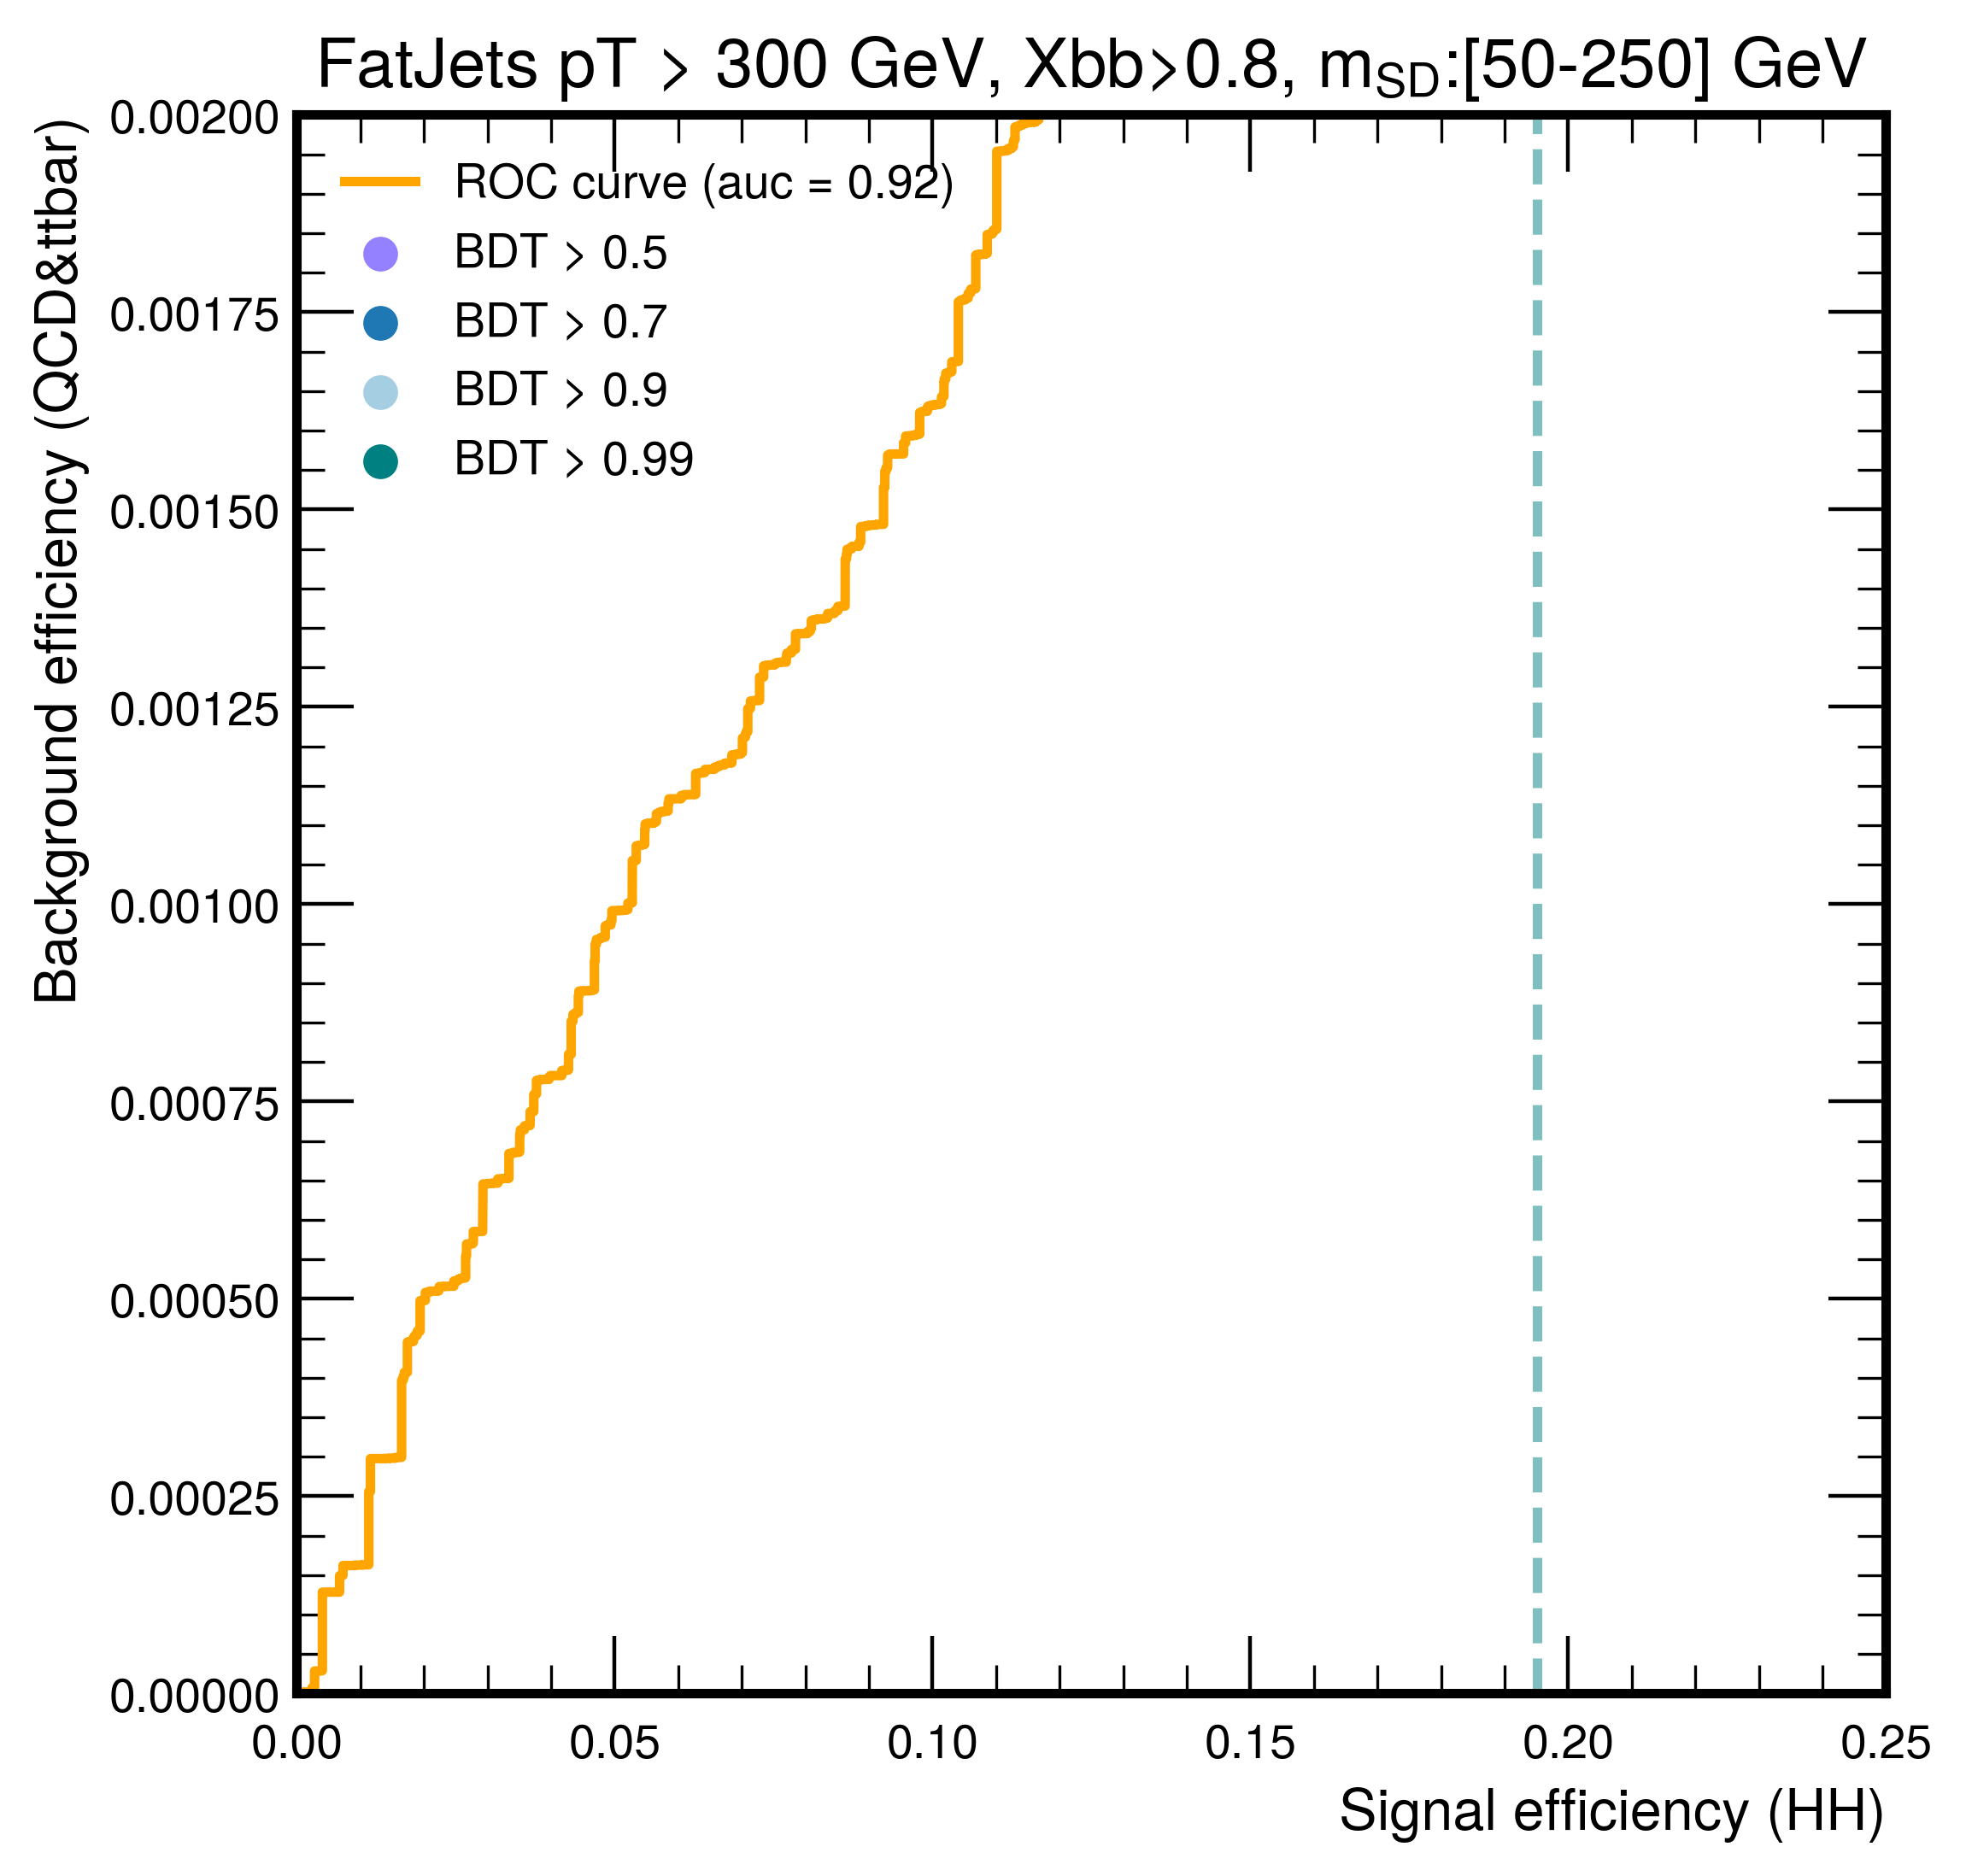

In [12]:
# Plottting ROC curve
plt.figure(figsize=(6, 6))
plt.plot(tpr, fpr, color="orange", lw=2, label="ROC curve (auc = %0.2f)" % roc_auc)

plot_thresholds = [0.5, 0.7, 0.9, 0.99]
th_colours = ["#9381FF", "#1f78b4", "#a6cee3", "teal"]
pths = {th: [[], []] for th in plot_thresholds}
print(plot_thresholds)
for th in plot_thresholds:
    idx = find_nearest(thresholds, th)
    pths[th][0].append(tpr[idx])
    pths[th][1].append(fpr[idx])
print(pths)

for k, th in enumerate(plot_thresholds):
    print(k, th)
    plt.scatter(
        *pths[th],
        marker="o",
        s=40,
        label=rf"BDT > {th}",
        color=th_colours[k],
        zorder=100,
    )

    plt.vlines(
        x=pths[th][0],
        ymin=0,
        ymax=pths[th][1],
        color=th_colours[k],
        linestyles="dashed",
        alpha=0.5,
    )

    plt.hlines(
        y=pths[th][1],
        xmin=0,
        xmax=pths[th][0],
        color=th_colours[k],
        linestyles="dashed",
        alpha=0.5,
    )

plt.title(r"FatJets pT > 300 GeV, Xbb>0.8, m$_{SD}$:[50-250] GeV")
plt.xlabel("Signal efficiency (HH)")
plt.ylabel("Background efficiency (QCD&ttbar)")
plt.legend(loc="upper left")
plt.xlim([0.0, 0.25])
plt.ylim([0, 0.002])
plt.savefig(f"{MAIN_DIR}/../data/boosted-bdt/ROC_BDT_weights.png")
plt.show()

In [14]:
scores_dict = {}
for key in ["hh4b", "qcd", "ttbar"]:
    pdf = events_dict_bdt[key].drop(columns=variables_not_in_bdt)
    scores_dict[key] = bdt_model.predict_proba(pdf)[:, 1]

In [32]:
X_test[X_test.index.get_level_values(0) == "qcd"]

HHlogPt     HHeta       HHmass        MET     H1T32     H2T32  \
qcd 21740   3.828672 -3.019177  1282.620112  81.655533  0.631153  0.628146   
    88181   4.195952  4.188499  2455.759249  56.424625  0.672575  0.886500   
    90130   5.195845  2.101470   935.156009  34.362717  0.653240  0.643320   
    69935   5.061036  2.125624   745.203042  16.718575  0.751806  0.950553   
    120263  5.982160 -1.716624   918.795274  72.332764  0.956783  0.791136   
...              ...       ...          ...        ...       ...       ...   
    75564   4.665548 -3.410187  1232.418562  79.422920  0.733184  0.854991   
    96815   3.869532 -3.269724  3077.874232  94.363091  0.794071  0.815439   
    69323   4.484138  2.685168  1126.988960  71.006081  0.784452  0.970187   
    55870   5.825585 -1.904922  1267.596440  59.968277  0.852242  0.719830   
    6036    4.453606 -4.011354   890.786407  22.017393  0.758427  0.842334   

                H1Msd   H1logPt   H2logPt     H1eta     H2eta     H1Xbb  \
qcd 21740   217.87500  6.395006  6.322396 -0.739990  0.026756  0.832031   
    88181   134.50000  6.767189  6.827967 -0.039932  1.612549  0.966797   
    90130    57.15625  5.904028  5.919389  1.440430 -0.008785  0.829102   
    69935    51.78125  5.719947  5.951136  0.337891  1.150879  0.988281   
    120263   70.56250  5.864682  6.429717 -0.865356 -0.993896  0.929199   
...               ...       ...       ...       ...       ...       ...   
    75564   144.87500  6.078488  6.288268 -0.395081 -1.703369  0.884766   
    96815   112.93750  6.271927  6.265121 -1.930664  1.530029  0.829590   
    69323   161.25000  6.079279  6.254701  0.010029  1.037354  0.989746   
    55870   179.25000  6.134441  6.319769 -0.086563 -1.412842  0.897949   
    6036    104.81250  6.078891  6.078045 -1.734131 -1.716309  0.916504   

            H1QCD1HF  H1QCD2HF      H1QCD0HF  H1Pt_HHmass  H2Pt_HHmass  \
qcd 21740   0.087463  0.064758  5.440712e-04     0.466893     0.434194   
    88181   0.021774  0.011200  5.834736e-07     0.353808     0.375978   
    90130   0.020889  0.136963  9.304285e-05     0.391925     0.397992   
    69935   0.001172  0.010567  1.607077e-09     0.409135     0.515550   
    120263  0.001395  0.069214  4.592948e-11     0.383513     0.674795   
...              ...       ...           ...          ...          ...   
    75564   0.026001  0.088989  2.309680e-07     0.354075     0.436719   
    96815   0.097900  0.024521  2.044678e-03     0.172033     0.170866   
    69323   0.000673  0.009727  1.261924e-10     0.387505     0.461809   
    55870   0.005253  0.096680  2.561137e-08     0.364060     0.438187   
    6036    0.003778  0.062622  1.621246e-05     0.490067     0.489652   

            H1Pt/H2Pt  
qcd 21740    1.075310  
    88181    0.941032  
    90130    0.984757  
    69935    0.793589  
    120263   0.568340  
...               ...  
    75564    0.810762  
    96815    1.006828  
    69323    0.839103  
    55870    0.830832  
    6036     1.000847  

[242482 rows x 18 columns]

In [42]:
X_test[X_test.index.get_level_values(0) == "hh4b"].index.get_level_values(1)

Int64Index([56066, 79200, 19270, 15299,  1079, 53942, 28267, 25691, 79001,
            14085,
            ...
            11501, 26618, 79416, 45726, 30127, 34879, 43441, 83912, 45603,
            46785],
           dtype='int64', length=36853)

In [43]:
hh4b_indices = X_test[X_test.index.get_level_values(0) == "hh4b"].index.get_level_values(1)

In [45]:
events_dict["hh4b"].loc[hh4b_indices]

weight      MET_pt nFatJets  bbFatJetPt             bbFatJetEta  \
              0           0        0           0           1           0   
56066  0.000024  118.597328        3  454.641144  351.670624    1.179443   
79200  0.000025   52.180656        2  380.646820  317.545166   -0.038918   
19270  0.000098   59.578751        2  338.756683  353.626434   -0.567505   
15299  0.000021   60.913853        2  522.348877  440.697357    1.606201   
1079   0.000032   37.985279        2  437.388458  394.994080    0.421692   
...         ...         ...      ...         ...         ...         ...   
34879  0.000009   32.499340        2  614.999573  524.599243    0.810913   
43441  0.000017   90.689674        2  342.034668  396.883423   -1.393555   
83912  0.000091   65.629425        2  306.210236  384.481232    0.330933   
45603  0.000377   94.696747        2  466.092041  377.508026    0.934448   
46785  0.000034  205.829300        3  493.385162  622.142517   -0.114548   

                bbFatJetPhi           bbFatJetMsd  ... bbFatJetPNetXbb  \
              1           0         1           0  ...               1   
56066  1.708740    2.922852  0.247131    113.8125  ...        0.891113   
79200 -0.024471   -2.645996  0.594727    118.1250  ...        0.367432   
19270 -0.246521   -1.522705  1.580078    116.9375  ...        0.895508   
15299  0.454712    0.595947 -2.408203    228.2500  ...        0.463867   
1079   0.237823   -0.004761 -3.061523    129.5000  ...        0.886719   
...         ...         ...       ...         ...  ...             ...   
34879 -0.790527   -2.645508  0.568848    127.0625  ...        0.172852   
43441 -0.168213    2.489258 -0.626221    129.0000  ...        0.406250   
83912  0.226990    2.295898 -0.885132     70.5000  ...        0.837402   
45603  0.691284   -3.092285  0.064072    110.3750  ...        0.979492   
46785 -0.312805    0.183624 -2.564941    112.5000  ...        0.948730   

      bbFatJetTau3OverTau2           bbFatJetPNetQCD0HF                \
                         0         1                  0             1   
56066             0.829587  0.741935       1.843728e-08  5.539507e-06   
79200             0.864954  0.780459       1.355074e-07  5.307198e-04   
19270             0.631519  0.639263       1.571607e-08  7.371418e-07   
15299             0.640947  0.569132       1.175329e-06  7.352829e-04   
1079              0.824561  0.830604       2.793968e-08  1.663284e-08   
...                    ...       ...                ...           ...   
34879             0.671919  0.708876       9.364448e-07  7.476807e-03   
43441             0.788321  0.880319       1.348089e-07  2.455711e-04   
83912             0.815194  0.691954       1.545231e-09  3.542900e-04   
45603             0.494071  0.662917       8.031975e-11  1.295120e-09   
46785             0.908491  0.837135       5.843503e-10  1.356966e-09   

      bbFatJetPNetQCD1HF           bbFatJetPNetQCD2HF           weight_nonorm  
                       0         1                  0         1                
56066           0.001904  0.055481           0.013588  0.052643    158.846836  
79200           0.004604  0.502441           0.024124  0.116211    165.371451  
19270           0.004284  0.005146           0.025040  0.095093    645.596799  
15299           0.013847  0.467529           0.119934  0.050537    140.054188  
1079            0.004192  0.005810           0.054108  0.107239    212.446209  
...                  ...       ...                ...       ...           ...  
34879           0.002439  0.106995           0.119934  0.129517     59.723864  
43441           0.000701  0.568359           0.001656  0.020233    113.357656  
83912           0.010880  0.070312           0.103088  0.078430    601.495045  
45603           0.000688  0.002026           0.014153  0.018478   2490.804434  
46785           0.001191  0.002146           0.024139  0.049042    227.900357  

[36853 rows x 24 columns]

In [46]:
X_test[X_test.index.get_level_values(0) == "hh4b"]

HHlogPt     HHeta       HHmass         MET     H1T32     H2T32  \
hh4b 56066  5.353647  2.726912   839.776401  118.597328  0.829587  0.741935   
     79200  4.275182 -0.309251   734.570150   52.180656  0.864954  0.780459   
     19270  2.997624 -3.369326   739.292767   59.578751  0.631519  0.639263   
     15299  4.653218  3.325094  1161.459698   60.913853  0.640947  0.569132   
     1079   4.009771  2.344353   885.138670   37.985279  0.824561  0.830604   
...              ...       ...          ...         ...       ...       ...   
     34879  4.599114  0.856422  1540.791073   32.499340  0.671919  0.708876   
     43441  4.019732 -3.245375   904.422481   90.689674  0.788321  0.880319   
     83912  4.374901  1.612256   710.662403   65.629425  0.815194  0.691954   
     45603  4.486389  2.874361   878.974380   94.696747  0.494071  0.662917   
     46785  5.528505 -0.888856  1121.960990  205.829300  0.908491  0.837135   

               H1Msd   H1logPt   H2logPt     H1eta     H2eta     H1Xbb  \
hh4b 56066  113.8125  6.119508  5.862695  1.179443  1.708740  0.984375   
     79200  118.1250  5.941872  5.760620 -0.038918 -0.024471  0.971191   
     19270  116.9375  5.825282  5.868241 -0.567505 -0.246521  0.970703   
     15299  228.2500  6.258336  6.088358  1.606201  0.454712  0.864746   
     1079   129.5000  6.080822  5.978871  0.421692  0.237823  0.941406   
...              ...       ...       ...       ...       ...       ...   
     34879  127.0625  6.421622  6.262635  0.810913 -0.790527  0.867188   
     43441  129.0000  5.834912  5.983643 -1.393555 -0.168213  0.997559   
     83912   70.5000  5.724272  5.951895  0.330933  0.226990  0.885742   
     45603  110.3750  6.144383  5.933592  0.934448  0.691284  0.985352   
     46785  112.5000  6.201290  6.433169 -0.114548 -0.312805  0.974609   

            H1QCD1HF  H1QCD2HF      H1QCD0HF  H1Pt_HHmass  H2Pt_HHmass  \
hh4b 56066  0.001904  0.013588  1.843728e-08     0.541384     0.418767   
     79200  0.004604  0.024124  1.355074e-07     0.518190     0.432287   
     19270  0.004284  0.025040  1.571607e-08     0.458217     0.478331   
     15299  0.013847  0.119934  1.175329e-06     0.449735     0.379434   
     1079   0.004192  0.054108  2.793968e-08     0.494147     0.446251   
...              ...       ...           ...          ...          ...   
     34879  0.002439  0.119934  9.364448e-07     0.399145     0.340474   
     43441  0.000701  0.001656  1.348089e-07     0.378180     0.438825   
     83912  0.010880  0.103088  1.545231e-09     0.430880     0.541018   
     45603  0.000688  0.014153  8.031975e-11     0.530268     0.429487   
     46785  0.001191  0.024139  5.843503e-10     0.439753     0.554514   

            H1Pt/H2Pt  
hh4b 56066   1.292804  
     79200   1.198717  
     19270   0.957951  
     15299   1.185278  
     1079    1.107329  
...               ...  
     34879   1.172323  
     43441   0.861801  
     83912   0.796424  
     45603   1.234655  
     46785   0.793042  

[36853 rows x 18 columns]

In [23]:
events_dict["qcd"]

weight      MET_pt nFatJets   bbFatJetPt              bbFatJetEta  \
               0           0        0            0            1           0   
0       0.007724   86.204422        2  1111.169800   987.253113    0.035110   
1       0.009358    9.784183        2   892.365967   900.903870   -0.376038   
2       0.013237  168.238388        3   326.236359   685.460022   -1.048828   
3       0.003407   71.175758        2  1262.862549  1138.968018    1.530029   
4       0.006497   70.755608        2   968.691589   941.689575    0.743042   
...          ...         ...      ...          ...          ...         ...   
151302  0.077610   17.026316        2   716.357361   688.499451    0.835938   
151303  0.180602   45.945831        2   536.825989   724.854736   -0.498779   
151304  0.016969   53.291862        2   657.108276   685.969055   -0.835449   
151305  0.013460   58.747528        3   320.794281   336.223877   -1.172607   
151306  0.264893  123.678658        2   482.355103   594.014893    0.126495   

                 bbFatJetPhi           bbFatJetMsd  ... bbFatJetPNetXbb  \
               1           0         1           0  ...               1   
0      -1.322021   -2.040039  1.052246   171.62500  ...        0.003469   
1       0.740967    0.006315  3.132324   128.87500  ...        0.000871   
2      -0.577881    1.663086  0.852417    55.40625  ...        0.003366   
3       0.407959   -1.161865  1.976562    67.75000  ...        0.000006   
4       0.970459    2.301270 -0.861694   215.12500  ...        0.012917   
...          ...         ...       ...         ...  ...             ...   
151302  0.548584   -3.125000  0.098358   180.12500  ...        0.009613   
151303 -1.166260   -1.864746  1.268555   173.50000  ...        0.001577   
151304 -1.145020    2.422363 -0.769287    82.62500  ...        0.338379   
151305 -1.487549   -2.092285  2.653809    67.75000  ...        0.617676   
151306 -1.248291   -0.229706  2.960938   188.50000  ...        0.001179   

       bbFatJetTau3OverTau2           bbFatJetPNetQCD0HF            \
                          0         1                  0         1   
0                  0.633427  0.768713       1.401454e-05  0.417236   
1                  0.840816  0.697248       5.565584e-06  0.477783   
2                  0.782191  0.571605       9.674750e-11  0.307129   
3                  0.616651  0.870892       1.548004e-02  0.560059   
4                  0.872753  0.800979       8.111000e-04  0.129883   
...                     ...       ...                ...       ...   
151302             0.456637  0.787043       3.956258e-06  0.054230   
151303             0.791500  0.749793       5.778857e-07  0.260986   
151304             0.685597  0.821794       2.717570e-09  0.016144   
151305             0.744108  0.812042       7.742643e-05  0.031708   
151306             0.766359  0.821849       1.472980e-05  0.345703   

       bbFatJetPNetQCD1HF           bbFatJetPNetQCD2HF           weight_nonorm  
                        0         1                  0         1                
0                0.014618  0.236816           0.044708  0.049591  1.756547e+08  
1                0.005840  0.166260           0.031708  0.029984  2.128332e+08  
2                0.004616  0.115295           0.134399  0.035400  3.010385e+08  
3                0.008949  0.142212           0.001800  0.025452  7.748809e+07  
4                0.025879  0.200684           0.053009  0.441895  1.477685e+08  
...                   ...       ...                ...       ...           ...  
151302           0.012070  0.019943           0.122986  0.002283  2.778084e+10  
151303           0.119995  0.084229           0.010918  0.026886  6.464745e+10  
151304           0.002333  0.243408           0.039490  0.042389  6.074049e+09  
151305           0.027725  0.066650           0.066467  0.025177  4.818081e+09  
151306           0.017532  0.093689           0.066650  0.021286  9.481966e+10  

[606602 rows x 24 columns]

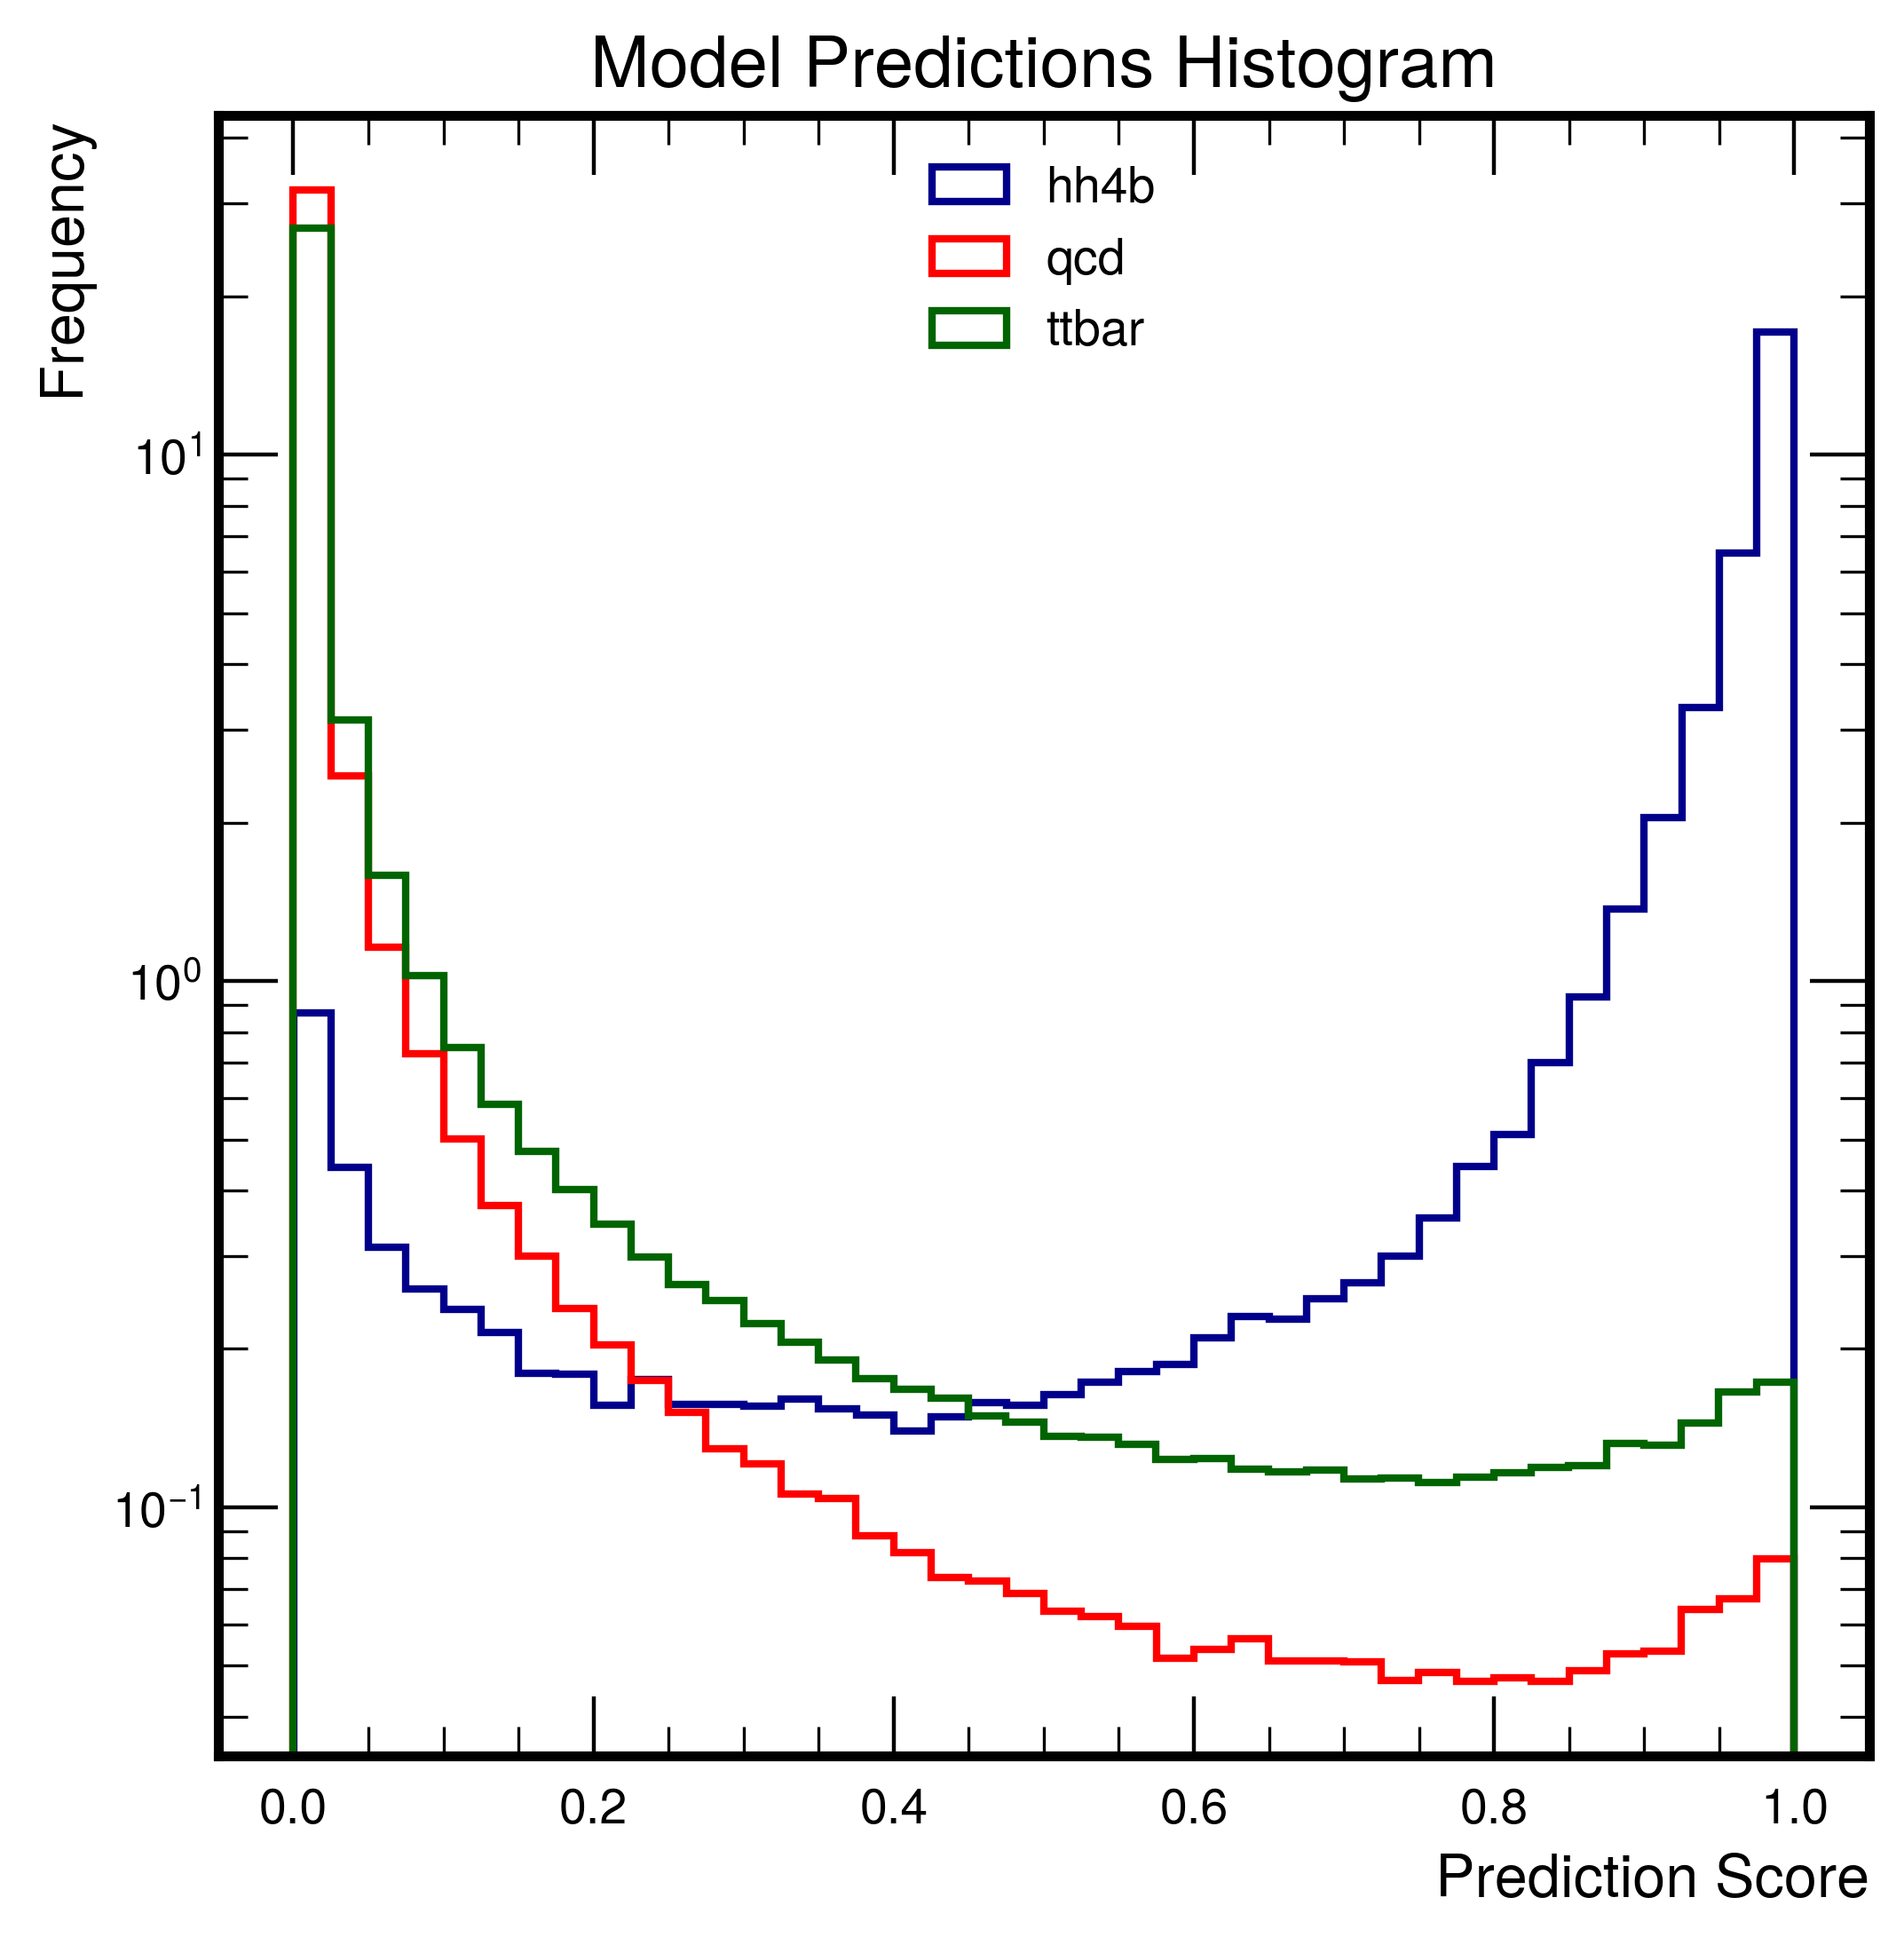

In [15]:
plt.figure(figsize=(6, 6))
plt.hist(
    scores_dict["hh4b"], bins=40, histtype="step", linewidth=1.5, color="darkblue", density=True
)
plt.hist(scores_dict["qcd"], bins=40, histtype="step", linewidth=1.5, color="red", density=True)
plt.hist(
    scores_dict["ttbar"], bins=40, histtype="step", linewidth=1.5, color="darkgreen", density=True
)
plt.legend(["hh4b", "qcd", "ttbar"])
plt.ylabel("Frequency")
plt.xlabel("Prediction Score")
plt.title("Model Predictions Histogram")
plt.yscale("log")
plt.show()

In [ ]:
cat_axis = hist.axis.StrCategory([], name="Sample", growth=True)
cut_axis = hist.axis.StrCategory([], name="Cut", growth=True)
h2_mass_axis = hist.axis.Regular(40, 0, 300, name="mass", label=r"Higgs 2 mass [GeV]")

hist_h2 = hist.Hist(h2_mass_axis, cut_axis, cat_axis)
bdt_cuts = [0.2]

for key in ["qcd"]:
    scores = scores_dict[key]
    events = events_dict_bdt[key]
    h2_mass = events["H2Msd"]

    for cut in bdt_cuts:
        mask = (
            (events["H1Msd"] > 50)
            & (events["H2Msd"] > 50)
            & (events["H1Msd"] < 250)
            & (events["H2Msd"] < 250)
            & (scores >= cut)
        )
        print(h2_mass[mask])
        hist_h2.fill(h2_mass[mask], str(cut), key)

In [ ]:
for key in ["qcd"]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    for cut in bdt_cuts:
        hep.histplot(hist_h2[{"Sample": key, "Cut": str(cut)}], lw=2, label=f"BDT > {cut}")
    ax.legend()
    ax.set_ylabel("Density")
    ax.set_title(key)

In [ ]:
bdt_axis = hist.axis.Regular(40, 0, 1, name="bdt", label=r"BDT")
xbb_axis = hist.axis.Regular(40, 0.7, 1, name="xbb", label=r"Xbb")
msd_axis = hist.axis.Regular(40, 0, 250, name="msd", label=r"m$_{SD}$ GeV")

cat_axis = hist.axis.StrCategory([], name="cat", growth=True)

h_bdt = hist.Hist(bdt_axis, cat_axis)
h_xbb0 = hist.Hist(xbb_axis, cat_axis)
h_msd1 = hist.Hist(msd_axis, cat_axis)

for key in ["qcd"]:
    events = events_dict_bdt[key]
    scores = scores_dict[key]
    mask = (
        (events["H1Msd"] > 50)
        & (events["H2Msd"] > 50)
        & (events["H1Msd"] < 250)
        & (events["H2Msd"] < 250)
        & (scores > 0.0)
    )

    print(h2_mass[mask])
    h_bdt.fill(bdt=scores[mask], cat=key)
    h_xbb0.fill(xbb=events[mask]["H1Xbb"].to_numpy(), cat=key)
    h_msd1.fill(msd=events[mask]["H2Msd"].to_numpy(), cat=key)


colors = {"ttbar": "b", "hh4b": "k", "qcd": "r"}

hists = {
    "bdt": h_bdt,
    "xbb_0": h_xbb0,
    "msd_1": h_msd1,
    # "mreg_1": h_mreg1,
}

for hname, hhist in hists.items():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for key in ["qcd"]:
        hep.histplot(
            hhist[{"cat": key}],
            ax=ax,
            label=f"{key}",
            histtype="step",
            linewidth=1,
            color=colors[key],
            density=True,
        )

    ax.set_yscale("log")
    ax.legend(title=r"FatJets $p_T>$300, m$_{SD}$:[50-250] GeV")
    ax.set_ylabel("Density")
    ax.set_title("Pre-Selection")
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True, which="major")